# Overview

The data ingestion from the **acure_aircraft** simulations is done through a series of interacting C3 Types that compose layers of abstraction/encapsulation. Even though these layes are intended to facilitate the end-client to promptly access the data using just a few calls, it is useful to understand this structure in case it needs modified at some point.


### Source Types
These are types that define the fields to be used from data that is *seeded*, as it is the case of *UKESM_PPE_Unit.csv*, which was renamed to *SimulationModelParametersMap.csv* (an *ensemble_id* column was also added).
- **SourceSimulationModelParametersMap**: collects data from *SimulationModelParametersMap.csv*
- **SourceSimulationEnsemble**: collects data from *SimulationEnsemble.csv*


### Entity Types
These are types whose fields are upserted to actual tables iin or accessible to the C3 server where this notebook is running. They are somewhat hyerarchical, but they also work cooperatively/horizontaly, so a complete top-down description may not capture their relationship as much as an ERD would, but I'll give it a try:
- **SimulationEnsemble**: an instance of this type contains a set of SimulationSamples. So far we only have one instance (acure_aircraft).
- **SimulationSample**: each SimulationEnsemble has many SimulationSamples. acure_aircraft has 221 samples.
- **SimulationModelParameters**: each SimulationSample has a corresponding set of parameters that are inputs to the simulation model.
- **SimulationOutputFile**: each SimulationSample has many output files (NetCDF). This type stores information about all output files for the SimulationSamples in all SimulationEnsembles.
- **SimulationModelOutput**: this is the actual data that comes out of the SimulationOutputFiles. This is filled when each of them is opened using NetCDFUtil.
- **SimulationModelOutputSeries**: since the data is by nature a Timeseries, this is the final Type where the data is efficiently stored in a key-value database (Cassandra), which can be fetched via evalMetrics (see below). We have chosen the parent field as the timeseries the SimulationSample instances: each SimulationSample has a Timeseries associated to it.

### Additional supporting Types
- **NetCDFUtil**: this is a utility type to open and close NetCDF files.
- **UpsertData**: this is another utility type to batch-process all the files in the SimulationOutputFile table.

# Imports



In [5]:
import pandas as pd
#import cartopy
#print(cartopy.__version__)
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt


# Wrangling NetCDF files: just for fun

All the files are now stored in an Azure Blob (gordon-group). The root URL for this folder is

https://devdtistore01.blob.core.windows.net/dev-dti/fs/dti/mpodolsky/gordon-group/

**This is just a demonstration of how to use the NetCDFUtil. You should not have to do that, because we built methods to upsert the data from all NetCDF file at SimulationEnsemble and SimulationSample levels.**

In [1]:
blob_root = 'https://devdtistore01.blob.core.windows.net/dev-dti/fs/dti/mpodolsky/gordon-group/'
file_path = 'acure_aircraft/u-bs714_ens000/'
file_name = blob_root + file_path + 'bs714a.flight_track_20170201.nc'

# here's a C3 Type -- NetCDFUtil to open the file and return the Dataset
sample = c3.NetCDFUtil.openFile(file_name)

print(sample)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    dimensions(sizes): dim0(116)
    variables(dimensions): float64 latitude(dim0), float64 time(dim0), float64 longitude(dim0), float64 altitude(dim0), float64 model_level_number(dim0), float64 number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air(dim0), float64 mass_fraction_of_sulfuric_acid_in_soluble_nucleation_mode_dry_aerosol_in_air(dim0), float64 number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air(dim0), float64 mass_fraction_of_sulfuric_acid_in_soluble_aitken_mode_dry_aerosol_in_air(dim0), float64 mass_fraction_of_black_carbon_in_soluble_aitken_mode_dry_aerosol_in_air(dim0), float64 mass_fraction_of_particulate_organic_matter_in_soluble_aitken_mode_dry_aerosol_in_air(dim0), float64 number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air(dim0), float64 mass_fraction_of_sulfuric_acid_in_soluble_accum

In [ ]:
sample.variables['longitude'][:]

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
df = pd.DataFrame()

df['time'] = sample.variables['time'][:]
df['longitude'] = sample.variables['longitude'][:]
df['latitude'] = sample.variables['latitude'][:]
df['propertyX'] = sample.variables['mass_fraction_of_black_carbon_in_soluble_accumulation_mode_dry_aerosol_in_air'][:]

In [ ]:
zero_time = datetime(1970,1,1,0,0)

transformed_times = []
for time in df['time']:
    target_time = zero_time + timedelta(hours=time)
    transformed_times.append(target_time)

In [ ]:
df['datetime'] = transformed_times
df.drop(columns=['time'], inplace=True)

In [ ]:
df

This DataFrame is the core of the SimulationModelOutputSeries instances. 

# Prototyping Simple Metrics

Now that we have the Timeseries upserted to a Cassandra database, we can specify metrics that query the stored data and return the information we are interested in (we can define different granularity, time ranges, aggregation methods, etc). 

To start with, let's look at the time-evolution of **propertyX**, which is now renamed to **mass_BC_acc** to reflect what it really is, for a certain SimulationSample.


In [36]:
# define metric

bigbcacc_metric = c3.SimpleMetric(id = "AverageMassBCacc_Ensemble",
                            name = "AverageMassBCacc_Ensemble",
                            description = "Calculates average of massBCacc over ensemble",
                            srcType = "SimulationEnsemble",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(normalized.data.mass_BC_acc)"
                           )
bcacc_metric = c3.SimpleMetric(id = "AverageMassBCacc_SimulationSample",
                            name = "AverageMassBCacc_SimulationSample",
                            description = "Calculates average of massBCacc for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(avg(normalized.data.mass_BC_acc))"
                           )
ocacc_metric = c3.SimpleMetric(id = "AverageMassOCacc_SimulationSample",
                            name = "AverageMassOCacc_SimulationSample",
                            description = "Calculates average of massOCacc for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(avg(normalized.data.mass_OC_acc))"
                           )
bcait_metric = c3.SimpleMetric(id = "AverageMassBCait_SimulationSample",
                            name = "AverageMassBCait_SimulationSample",
                            description = "Calculates average of massBCait for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(avg(normalized.data.mass_BC_Ait))"
                           )
lon_metric = c3.SimpleMetric(id = "AverageLon_SimulationSample",
                            name = "AverageLon_SimulationSample",
                            description = "Calculates average of longitude for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(avg(normalized.data.longitude))"
                           )
lat_metric = c3.SimpleMetric(id = "AverageLat_SimulationSample",
                            name = "AverageLat_SimulationSample",
                            description = "Calculates average of latitude for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(avg(normalized.data.latitude))"
                           )
# define the specification -- start and end, interval, id of the sourceType (SimSam here)
my_spec = c3.EvalMetricsSpec(
            ids = ["EnsNo_1_SimNo_0"],
            expressions = ["AverageMassBCacc_SimulationSample","AverageMassBCait_SimulationSample",
                           "AverageLon_SimulationSample","AverageLat_SimulationSample", "AverageMassOCacc_SimulationSample"],
            start = "2017-01-01T00:00:00.000",
            end = "2017-12-31T23:59:59.000",
            interval = "HOUR" 
            )
mybig_spec = c3.EvalMetricsSpec(
            ids = ["EnsNo_1_SimNo_0"],
            expressions = ["AverageMassBCacc_Ensemble"],
            start = "2017-01-01T00:00:00.000",
            end = "2017-12-31T23:59:59.000",
            interval = "HOUR" 
            )

# evaluate the metric on the sourceType (SimSam)
evalMetricsResultSS = c3.SimulationSample.evalMetricsWithMetadata(
                                                                spec=my_spec,
                                                                overrideMetrics=[bcacc_metric,bcait_metric, 
                                                                                 lon_metric, lat_metric,ocacc_metric]#
                                                                )
evalMetricsResultSE = c3.SimulationSample.evalMetricsWithMetadata(
                                                                spec=mybig_spec,
                                                                overrideMetrics=[bigbcacc_metric]#
                                                                )

500 - NotClassified - c3.service.metric.SimpleMetricMethods_invalidMetric [1957.1483]
message: "Invalid metric 'AverageMassBCacc_Ensemble': MetricDepsUtil: Field 'output' not found in type 'SimulationEnsemble' for expression 'path' - 'output' in metric 'AverageMassBCacc_Ensemble' with source type 'SimulationEnsemble'."
JSON: {"overrideMetrics": [{"type": "SimpleMetric", "name": "AverageMassBCacc_Ensemble", "expression": "avg(normalized.data.mass_BC_acc)", "description": "Calculates average of massBCacc over ensemble", "id": "AverageMassBCacc_Ensemble", "srcType": {"type": "TypeRef", "typeName": "SimulationEnsemble"}, "path": "output"}], "spec": {"type": "EvalMetricsSpec", "start": "2017-01-01T00:00:00", "end": "2017-12-31T23:59:59", "timeZone": "NONE", "interval": "HOUR", "cache": false, "ids": ["EnsNo_1_SimNo_0"], "expressions": ["AverageMassBCacc_Ensemble"], "continueOnError": false}}


C3RuntimeException: 500 - NotClassified - c3.service.metric.SimpleMetricMethods_invalidMetric [1957.1483]
message: "Invalid metric 'AverageMassBCacc_Ensemble': MetricDepsUtil: Field 'output' not found in type 'SimulationEnsemble' for expression 'path' - 'output' in metric 'AverageMassBCacc_Ensemble' with source type 'SimulationEnsemble'."
JSON: {"overrideMetrics": [{"type": "SimpleMetric", "name": "AverageMassBCacc_Ensemble", "expression": "avg(normalized.data.mass_BC_acc)", "description": "Calculates average of massBCacc over ensemble", "id": "AverageMassBCacc_Ensemble", "srcType": {"type": "TypeRef", "typeName": "SimulationEnsemble"}, "path": "output"}], "spec": {"type": "EvalMetricsSpec", "start": "2017-01-01T00:00:00", "end": "2017-12-31T23:59:59", "timeZone": "NONE", "interval": "HOUR", "cache": false, "ids": ["EnsNo_1_SimNo_0"], "expressions": ["AverageMassBCacc_Ensemble"], "continueOnError": false}}

### Visualizing it as a Pandas DataFrame

In [35]:
# convert EvalMetricsResult to Pandas DataFrame
df = c3.EvalMetricsResult.toPandas(result=evalMetricsResultSS)
#df.sample(5)
import numpy as np
print(np.max(df['AverageMassBCacc_SimulationSample']))
print(np.max(df['AverageMassOCacc_SimulationSample']))
print(np.array(df['AverageMassBCacc_SimulationSample']).shape)

6.675480225101536e-10
8.032355557988373e-09
(8760,)


Looks like we need some postprocessing to get the timestamps (in Python, not from the browser console)...

In [8]:
# Post process dataframe to add 'timestamp' column
df['source'] = df.index.str.split('_').str[0:-1]
conc = []
for source in df['source']:
    conc.append("_".join(source))

df['source'] = conc
df['timestamp'] = pd.to_datetime(df.index.str.split('_').str[-1],format="%Y-%m-%dT%H:%M:%S.%f")

df.sample(5)

,AverageLat_SimulationSample,AverageLon_SimulationSample,AverageMassBCacc_SimulationSample,AverageMassBCait_SimulationSample,AverageMassOCacc_SimulationSample,source,timestamp
EnsNo_1_SimNo_0_2017-05-16T06:00:00,0.0,0.0,0.0,0.0,0.0,EnsNo_1_SimNo_0,2017-05-16 06:00:00
EnsNo_1_SimNo_0_2017-10-26T10:00:00,0.0,0.0,0.0,0.0,0.0,EnsNo_1_SimNo_0,2017-10-26 10:00:00
EnsNo_1_SimNo_0_2017-03-31T19:00:00,0.0,0.0,0.0,0.0,0.0,EnsNo_1_SimNo_0,2017-03-31 19:00:00
EnsNo_1_SimNo_0_2017-09-28T16:00:00,0.0,0.0,0.0,0.0,0.0,EnsNo_1_SimNo_0,2017-09-28 16:00:00
EnsNo_1_SimNo_0_2017-10-20T11:00:00,0.0,0.0,0.0,0.0,0.0,EnsNo_1_SimNo_0,2017-10-20 11:00:00


Much better!

### Plot it

<AxesSubplot:xlabel='timestamp'>

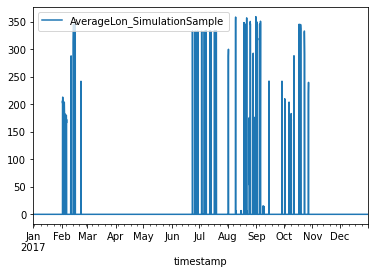

In [10]:
df.plot(x='timestamp',y='AverageLon_SimulationSample')

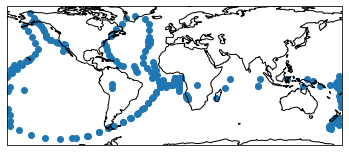

In [13]:
plt.subplot(111,projection=ccrs.PlateCarree())
plt.scatter(df['AverageLon_SimulationSample'],df['AverageLat_SimulationSample'])
plt.gca().coastlines()
